# Capstone project - HealthCare Fraud Detection : Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import confusion_matrix, classification_report, ROCAUC
from cp_clean_helper import show_values
from LGR_helper import std_num_cols, model_results, get_confusion_matrix
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

### # Loading datasets, dropping few columns, and looking at shapes:-

In [2]:
# Loading datasets

train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)

# Dropping some ID related features and created new model dfs

traindf = train_df.drop(['BeneID','ClaimID','Provider'], axis=1)
testdf = test_df.drop(['BeneID','ClaimID','Provider'], axis=1)

# Looking at dataset shapes

print('Shape of original train data :',train_df.shape)
print('Shape of original test data :',test_df.shape)
print('Shape of model train data :',traindf.shape)
print('Shape of model test data :',testdf.shape)

Shape of original train data : (558211, 61)
Shape of original test data : (135392, 60)
Shape of model train data : (558211, 58)
Shape of model test data : (135392, 57)


### # Separating independant and dependant variables:-

In [3]:
## Label Encoding PotentialFraud

label_encoder = preprocessing.LabelEncoder()
traindf['PotentialFraud'] = label_encoder.fit_transform(traindf['PotentialFraud'])

## Separating x and y variables for test train split

LGR_x = traindf.drop(['PotentialFraud'], axis=1)
LGR_y = traindf['PotentialFraud']

In [4]:
LGR_x

,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,Deceased,Age,Tot_Reimbursed_Amt,Tot_Deductible_Amt,DOB_year,DOB_month,DOB_day,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,Diag_Code_Cnt,Proc_Code_Cnt,Hospital_Stay,Claim_Duration,Claim_Start_Year,Claim_Start_Month,Insurance_Covered_Per,Total_Claim_Amt,Physician_Count,Claim_Count,Hospital_Count,Chr_Cond_Count
0,0,0,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,0,66,36060,3264,1943,1,1,26000,53276,0,0,3022,1068.0,154,1036,1770,2273,2981,538,2034,442,197,1357,1041,1117,300,154,36,3,6,6,2009,4,96.05,27068.0,3,1,1,4
1,0,0,0,39,510,12,12,1,1,1,1,1,1,0,0,0,1,1,0,65,1250,1250,1944,9,1,600,73124,0,0,3763,0.0,736,10069,4945,4206,3866,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,0,2009,12,100.00,600.0,21,2,2,8
2,1,0,1,33,70,12,12,1,0,0,1,1,1,1,0,1,1,0,0,74,2390,2390,1935,10,1,20,47058,0,0,3763,0.0,736,202,4704,4206,3866,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,0,2009,9,100.00,20.0,6,2,2,8
3,1,0,0,39,470,12,12,0,1,0,1,1,1,0,0,1,1,1,0,77,870,870,1932,6,1,30,40279,0,31218,3763,0.0,736,10379,1781,4206,3866,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,0,2009,3,100.00,30.0,12,1,1,7
4,0,0,0,39,310,12,12,0,0,0,1,1,1,1,0,1,1,1,0,77,24450,2586,1932,5,1,50,36530,4694,0,3763,0.0,736,10274,2335,3352,1507,3351,2402,2443,304,1629,1041,1117,300,154,0,0,-1,0,2009,9,100.00,50.0,3,3,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,0,0,0,21,230,12,12,1,1,0,0,0,1,0,0,1,1,1,0,67,17540,3608,1942,1,1,1900,81112,0,0,253,0.0,736,1562,4704,4206,3866,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,0,2009,9,100.00,1900.0,0,0,0,6
558207,1,0,1,5,200,12,12,0,0,0,1,0,1,0,0,1,1,1,0,63,14240,14240,1946,6,1,2100,18069,0,0,3763,0.0,736,5148,3779,4206,3866,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,20,2009,7,100.00,2100.0,0,0,0,6
558208,1,0,0,16,490,12,12,1,0,0,0,0,0,0,0,0,0,1,0,85,640,640,1924,8,1,10,70375,0,0,3763,0.0,736,4066,4704,4206,3866,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,0,2009,4,100.00,10.0,0,0,0,2
558209,1,0,0,43,170,12,12,1,1,1,0,1,1,0,0,0,0,0,0,66,3220,3220,1943,8,1,60,54268,0,30844,3763,0.0,736,10097,4981,3580,3912,3502,3187,2991,2720,2453,1041,1117,300,154,0,0,-1,0,2009,9,100.00,60.0,0,0,0,5


In [5]:
LGR_y # 1: Possible-fraud (Yes), 0: Non-fraud (No)

0         1
1         1
2         1
3         1
4         1
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: PotentialFraud, Length: 558211, dtype: int32

In [6]:
LGR_y.value_counts(normalize=True)*100 # Imbalanced classes

0    61.878931
1    38.121069
Name: PotentialFraud, dtype: float64

## Train-Test split:

In [7]:
# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(LGR_x, LGR_y, random_state=42,\
                                                shuffle=True, stratify=LGR_y, test_size=0.3)

# Looking at dataset shapes

print('Shape of imbalanced trainX data :',trainX.shape)
print('Shape of imbalanced trainY data :',trainY.shape)
print('Shape of imbalanced testX data :',testX.shape)
print('Shape of imbalanced testY data :',testY.shape)
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY) :',trainY.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY) :',testY.value_counts(normalize=True)*100)
print('\n')
print("*"*60)

Shape of imbalanced trainX data : (390747, 57)
Shape of imbalanced trainY data : (390747,)
Shape of imbalanced testX data : (167464, 57)
Shape of imbalanced testY data : (167464,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY) : 0    61.878914
1    38.121086
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY) : 0    61.878971
1    38.121029
Name: PotentialFraud, dtype: float64


************************************************************


## SMOTE Upsampling:

In [8]:
# Upsampling the minority class via SMOTE

trainX_SM, trainY_SM = SMOTE(random_state=0).fit_resample(trainX, trainY)
testX_SM, testY_SM = SMOTE(random_state=0).fit_resample(testX, testY)

# Looking at dataset shapes

print('Shape of SMOTE balanced trainX data :',trainX_SM.shape)
print('Shape of SMOTE balanced trainY data :',trainY_SM.shape)
print('Shape of SMOTE balanced testX data :',testX_SM.shape)
print('Shape of SMOTE balanced testY data :',testY_SM.shape, end='\n')
print('\n')
print("*"*60)

# Looking at class ratios

print('\n')
print('Class ratio - Fraud/Non-Fraud (trainY_SM) :',trainY_SM.value_counts(normalize=True)*100)
print('Class ratio - Fraud/Non-Fraud (testY_SM) :',testY_SM.value_counts(normalize=True)*100, end='\n')
print('\n')
print("*"*60)

Shape of SMOTE balanced trainX data : (483580, 57)
Shape of SMOTE balanced trainY data : (483580,)
Shape of SMOTE balanced testX data : (207250, 57)
Shape of SMOTE balanced testY data : (207250,)


************************************************************


Class ratio - Fraud/Non-Fraud (trainY_SM) : 0    50.0
1    50.0
Name: PotentialFraud, dtype: float64
Class ratio - Fraud/Non-Fraud (testY_SM) : 0    50.0
1    50.0
Name: PotentialFraud, dtype: float64


************************************************************


## Standardizing the train/test features:

In [9]:
# Unbalanced Dataset

std_num_cols(trainX)
std_num_cols(testX)

# SMOTE Balanced Dataset

std_num_cols(trainX_SM)
std_num_cols(testX_SM)

# Baseline Logistic Regression Model - Unbalanced Data

In [10]:
# base_logit = LogisticRegression(solver='liblinear')
# model_results(trainX, trainY, testX, testY, base_logit, show=True)

In [11]:
# base_logit = LogisticRegression(solver='liblinear', class_weight='balanced')
# model_results(trainX, trainY, testX, testY, base_logit, show=True)

# Baseline Logistic Regression Model - SMOTE Balanced Data

In [12]:
# Baseline confusion matrix

testY_SM.value_counts()

0    103625
1    103625
Name: PotentialFraud, dtype: int64

In [13]:
# First Logistic Regression Baseline Model

base_logitsm1 = LogisticRegression(solver='liblinear')
model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, base_logitsm1, show=True)

The Model Results for  LogisticRegression(solver='liblinear')
************************************************************
Train Accuracy is equal to 0.634
Test Accuracy is equal to 0.635
The Precision score is 0.660
The Average Precision score is 0.589
The Recall score is 0.557
The F1 score is 0.605
The AUC/ROC score is 0.635
True-Positive: 57755.000
True-Negative: 73932.000
False-Positive: 29693.000
False-Negative: 45870.000
Correctly Classified: 131687.000
Incorrectly Classified: 75563.000


[0.633843417841929, 0.6354016887816647, 0.6604496386423931, 0.5573462002412545]

In [14]:
# Looking at confusion matrix

get_confusion_matrix(base_logitsm1, testX_SM, testY_SM)

array([[73932, 29693],
       [45870, 57755]], dtype=int64)

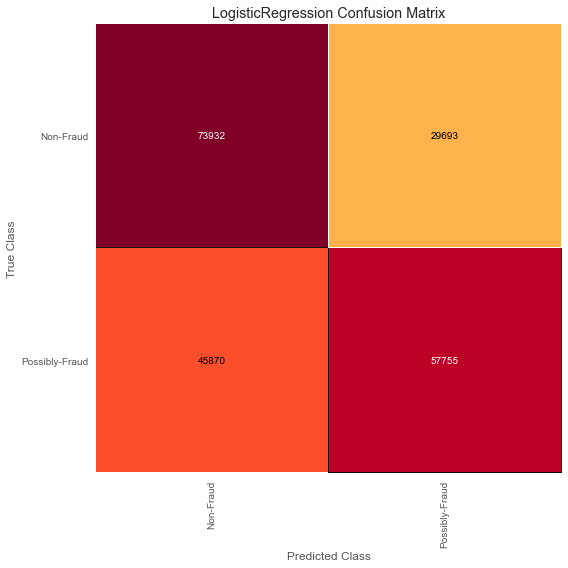

ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['Non-Fraud', 'Possibly-Fraud'],
                cmap=<matplotlib.colors.ListedColormap object at 0x000001A009E3ACD0>,
                estimator=LogisticRegression(solver='liblinear'))

In [15]:
# Visualizing the confusion matrix with Yellowbricks

plt.figure(figsize = (8,8))
confusion_matrix(
    base_logitsm1,
    trainX_SM, trainY_SM, testX_SM, testY_SM,
    classes=['Non-Fraud', 'Possibly-Fraud']
)

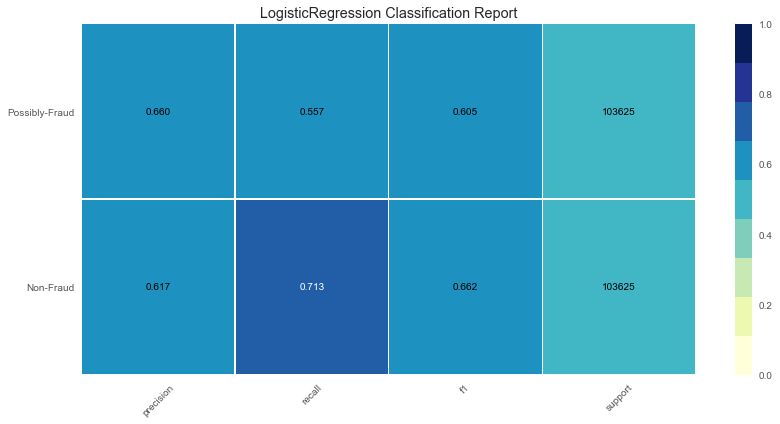

In [16]:
# Visualizing the classification report with Yellowbricks

plt.figure(figsize = (12,6))
visualizer = classification_report(
    base_logitsm1,
    trainX_SM, trainY_SM, testX_SM, testY_SM,
    classes=['Non-Fraud', 'Possibly-Fraud'],
    cmap='YlGnBu',
    support=True
)

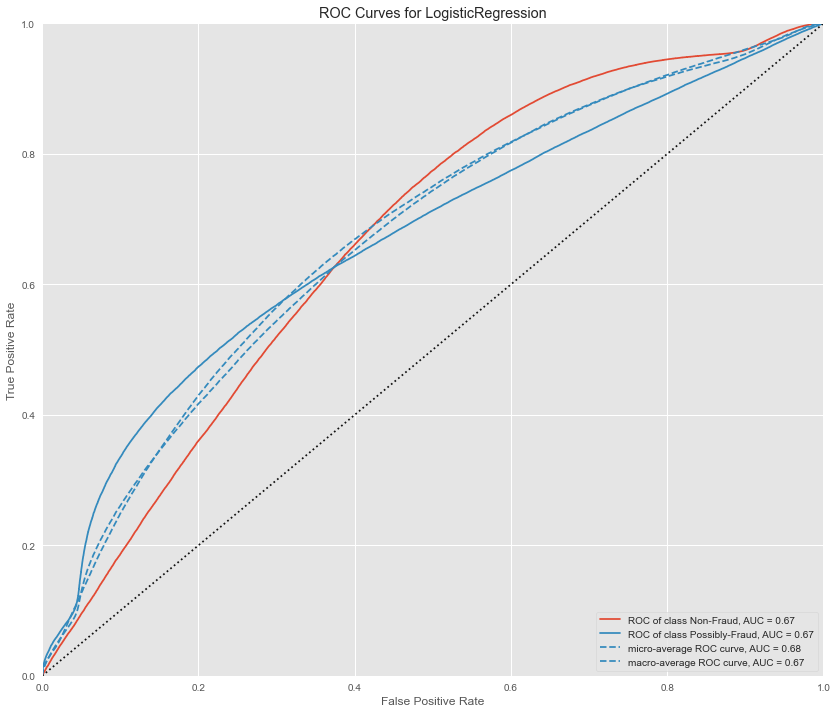

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))

visualizer = ROCAUC(base_logitsm1, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_SM, trainY_SM)        # Fit the training data to the visualizer
visualizer.score(testX_SM, testY_SM)        # Evaluate the model on the test data
visualizer.show()                           # Finalize and render the figure

In [18]:
# Dropping some additional features to evaluate performance

trainX_SM = trainX_SM.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                            'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                            'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                            'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

testX_SM = testX_SM.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','ChronicCond_Alzheimer',\
                          'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',\
                          'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',\
                          'ChronicCond_Depression', 'ChronicCond_Diabetes',\
                          'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',\
                          'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'], axis=1)

In [19]:
base_logitsm = LogisticRegression(solver='liblinear')
model_results(trainX_SM, trainY_SM, testX_SM, testY_SM, base_logitsm1, show=True)

The Model Results for  LogisticRegression(solver='liblinear')
************************************************************
Train Accuracy is equal to 0.693
Test Accuracy is equal to 0.693
The Precision score is 0.852
The Average Precision score is 0.664
The Recall score is 0.467
The F1 score is 0.603
The AUC/ROC score is 0.693
True-Positive: 48406.000
True-Negative: 95209.000
False-Positive: 8416.000
False-Negative: 55219.000
Correctly Classified: 143615.000
Incorrectly Classified: 63635.000


[0.6926196286033335,
 0.6929553679131484,
 0.8518883531026715,
 0.4671266586248492]

In [20]:
# Looking at confusion matrix

get_confusion_matrix(base_logitsm1, testX_SM, testY_SM)

array([[95209,  8416],
       [55219, 48406]], dtype=int64)

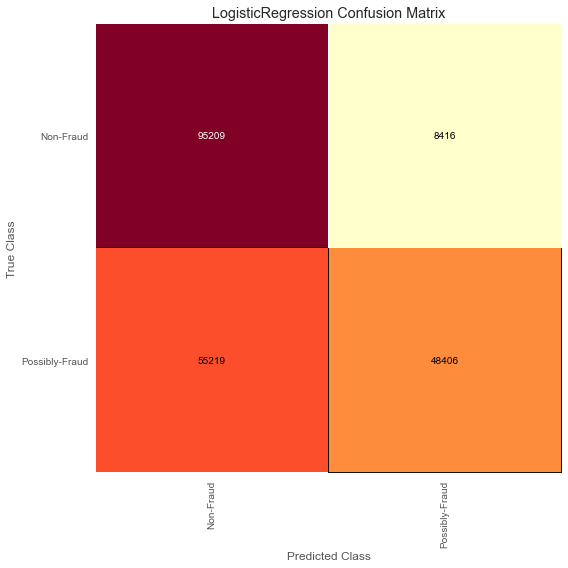

ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['Non-Fraud', 'Possibly-Fraud'],
                cmap=<matplotlib.colors.ListedColormap object at 0x000001A00A4BAC10>,
                estimator=LogisticRegression(solver='liblinear'))

In [21]:
# Visualizing the confusion matrix with Yellowbricks

plt.figure(figsize = (8,8))
confusion_matrix(
    base_logitsm1,
    trainX_SM, trainY_SM, testX_SM, testY_SM,
    classes=['Non-Fraud', 'Possibly-Fraud']
)

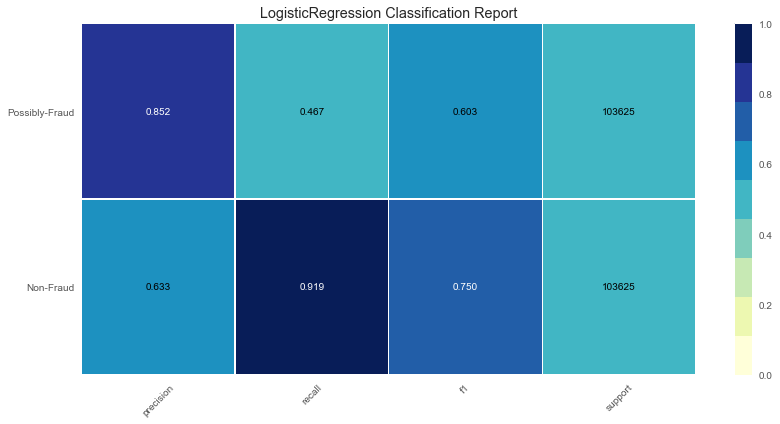

In [22]:
# Visualizing the classification report with Yellowbricks

plt.figure(figsize = (12,6))

visualizer = classification_report(
    base_logitsm1,
    trainX_SM, trainY_SM, testX_SM, testY_SM,
    classes=['Non-Fraud', 'Possibly-Fraud'],
    cmap='YlGnBu',
    support=True
)

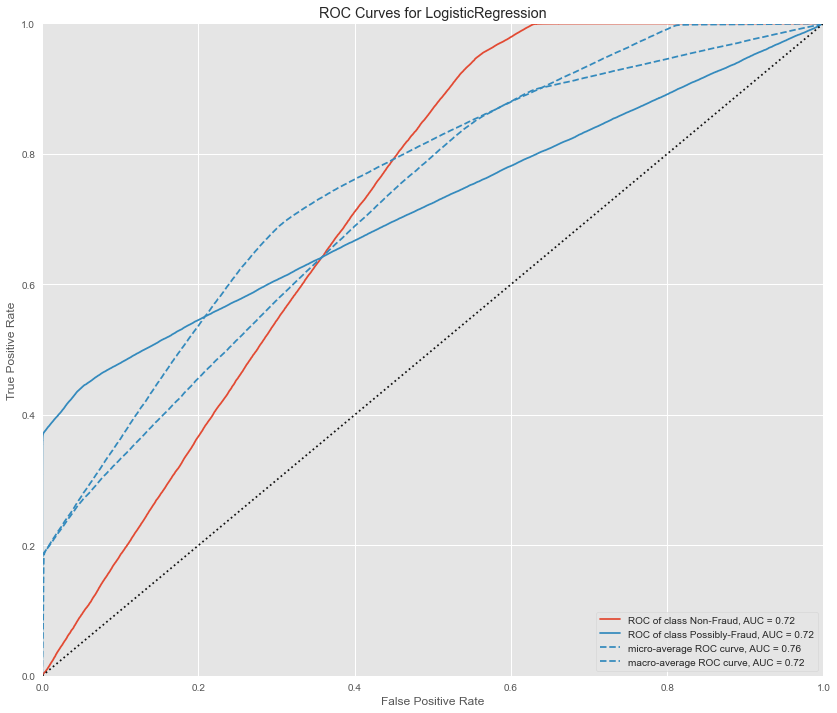

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [23]:
# Visualizing the AUC/ROC curve with Yellowbricks

plt.figure(figsize = (14,12))
visualizer = ROCAUC(base_logitsm1, classes=['Non-Fraud', 'Possibly-Fraud'])

visualizer.fit(trainX_SM, trainY_SM)        # Fit the training data to the visualizer
visualizer.score(testX_SM, testY_SM)        # Evaluate the model on the test data
visualizer.show()                           # Finalize and render the figure